In [ ]:
!pip install wandb

In [2]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt
import wandb
from wandb.keras import (
   WandbMetricsLogger,
   WandbModelCheckpoint,
)

In [ ]:
run = wandb.init(project="7-7_faces")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
config = wandb.config

In [ ]:
wandb_callbacks = [
   WandbMetricsLogger(log_freq=5),
   WandbModelCheckpoint("models.keras"),
]

### Preparing Dataset

In [3]:
dataset_path = "7-7-faces"
width = height = 224

image_data_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1,

    #data augmentation
    horizontal_flip=True,
    brightness_range=(0.8, 1.2)
)

train_data = image_data_generator.flow_from_directory(
    dataset_path,
    target_size=(width, height),
    subset='training',
    shuffle=True,
    batch_size=32
)

validation_data = image_data_generator.flow_from_directory(
    dataset_path,
    target_size=(width, height),
    subset='validation',
    shuffle=False,
    batch_size=32
)

Found 1227 images belonging to 14 classes.
Found 131 images belonging to 14 classes.


In [8]:
next(train_data)[0].shape

(32, 224, 224, 3)

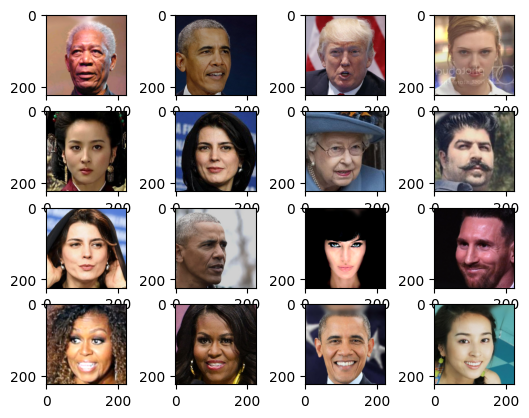

In [10]:
train_images = next(train_data)[0]

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(train_images[i])

### Create Model

In [4]:
base_model = tf.keras.applications.MobileNetV2()

In [ ]:
base_model.summary()

In [5]:
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights="imagenet",     #Transfer Learning
    input_shape=(width, height, 3),
    pooling="avg"
)

In [ ]:
base_model.summary()

In [6]:
for layer in base_model.layers[0:-4]:
    layer.trainable=False

In [ ]:
base_model.summary()

In [7]:
model = Sequential([
    base_model,
    layers.Dropout(0.2),
    layers.Dense(14, activation='softmax')
])

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 14)             │        17,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,275,918 (8.68 MB)

 Trainable params: 430,094 (1.64 MB)

 Non-trainable params: 1,845,824 (7.04 MB)

In [8]:
model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=RMSprop(learning_rate=1e-4),      #0.0001
    metrics=['accuracy']
)

In [ ]:
history = model.fit(train_data,
                    validation_data=validation_data,
                    epochs=32,
                    callbacks=wandb_callbacks
                    )

Epoch 1/32


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 587s 12s/step - accuracy: 0.3327 - loss: 2.1769 - val_accuracy: 0.6260 - val_loss: 1.3757
Epoch 2/32
39/39 ━━━━━━━━━━━━━━━━━━━━ 15s 321ms/step - accuracy: 0.7575 - loss: 1.0054 - val_accuracy: 0.6489 - val_loss: 1.0023
Epoch 3/32
39/39 ━━━━━━━━━━━━━━━━━━━━ 15s 318ms/step - accuracy: 0.8698 - loss: 0.6057 - val_accuracy: 0.6870 - val_loss: 0.8646
Epoch 4/32
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 314ms/step - accuracy: 0.9027 - loss: 0.4387 - val_accuracy: 0.7252 - val_loss: 0.7422
Epoch 5/32
39/39 ━━━━━━━━━━━━━━━━━━━━ 15s 313ms/step - accuracy: 0.9430 - loss: 0.3219 - val_accuracy: 0.7481 - val_loss: 0.7229
Epoch 6/32
39/39 ━━━━━━━━━━━━━━━━━━━━ 15s 314ms/step - accuracy: 0.9475 - loss: 0.2555 - val_accuracy: 0.7863 - val_loss: 0.6070
Epoch 7/32
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 334ms/step - accuracy: 0.9677 - loss: 0.2299 - val_accuracy: 0.7939 - val_loss: 0.5957
Epoch 8/32
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 316ms/step - accuracy: 0.9758 - loss: 0.1614 - val_accuracy: 0.8168

In [ ]:
# without dropout: accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 0.9008 - val_loss: 0.3806
# with dropout: accuracy: 1.0000 - loss: 0.0070 - val_accuracy: 0.8626 - val_loss: 0.4288

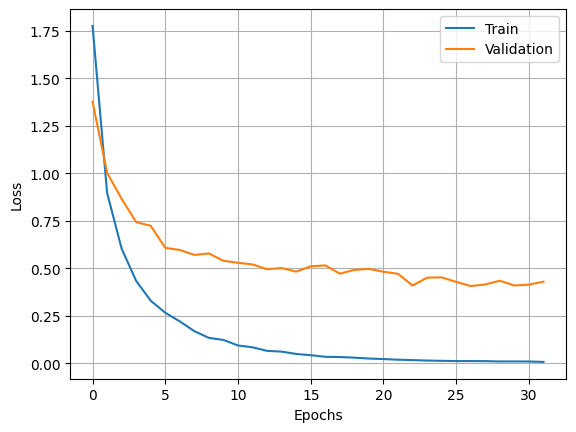

In [ ]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.show()

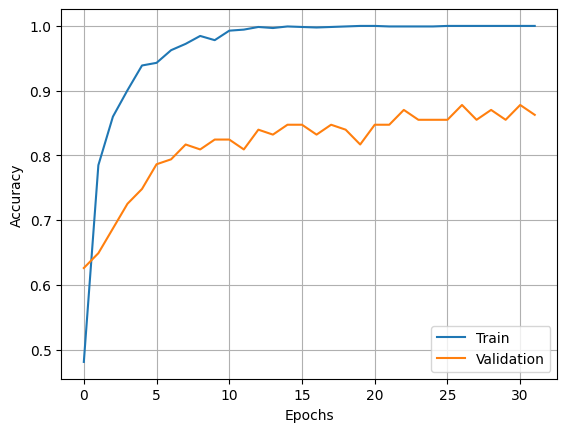

In [ ]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

In [ ]:
model.save("7-7-faces_model_dropout.h5")
model.save("7-7-faces_model_dropout.keras")

In [9]:
train_data.class_indices

{'Ali_Khamenei': 0,
 'Angelina_Jolie': 1,
 'Barak_Obama': 2,
 'Behnam_Bani': 3,
 'Donald_Trump': 4,
 'Emma_Watson': 5,
 'Han_Hye_Jin': 6,
 'Kim_Jong_Un': 7,
 'Leyla_Hatami': 8,
 'Lionel_Messi': 9,
 'Michelle_Obama': 10,
 'Morgan_Freeman': 11,
 'Queen_Elizabeth': 12,
 'Scarlett_Johansson': 13}

In [14]:
train_data.class_indices.values()

dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])

In [10]:
labels_list = []
for value in train_data.class_indices.values():
    labels_list.append(value)

labels_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [11]:
y_pred = model.predict(validation_data)
y_predict = np.argmax(y_pred , axis=1)

d:\Program Files\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step


In [13]:
print(y_pred)
print(y_predict)

[[0.03757279 0.14435631 0.01818122 ... 0.01295721 0.0514384  0.17268856]
 [0.15485057 0.09091429 0.03417202 ... 0.01145309 0.01699387 0.10859548]
 [0.08500692 0.0446533  0.02399991 ... 0.04163548 0.02482324 0.23930705]
 ...
 [0.06355263 0.06463015 0.01624342 ... 0.00748313 0.05735577 0.10858213]
 [0.02102078 0.05732022 0.03531753 ... 0.00485546 0.04115923 0.12685177]
 [0.08031884 0.03495316 0.01347136 ... 0.01888312 0.02893782 0.07030342]]
[13  5 13  7  9  6  6  6  6  8  3  0  9  3  8  8  1 13  8 13 13  9  0  0
  0 13  8 13  8 13 13  0  0  8  9  0  8 13  9  9  8  9 13  1  8 13  9  9
 13  9  5  8  9  9  8  5  5  0  8  5  4  0  8  5  8  8  9  1  5  9  3  9
  0  8  8  5  5  9  8  1  8  1 10 13  1 13  9  0  3  0  9 13  8  3  5  8
  8  8 13  9  7  0  9  8  8 13  9 13  9  8  0  6  9  9  7  9  9  9  9  5
 12  8  8  8 13  8  8  9  8  5  5]


In [14]:
validation_data.classes

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,
        5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,
        7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,
        9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13])

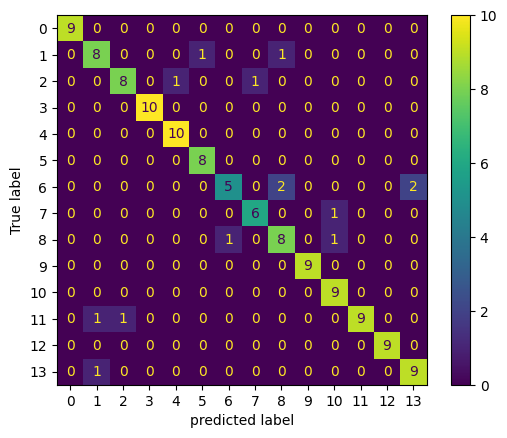

In [12]:
from sklearn import metrics

confusion_mat = metrics.confusion_matrix(validation_data.classes, y_predict)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_mat, 
                                            display_labels=labels_list)
cm_display.plot()
plt.xlabel("predicted label")
plt.ylabel("True label")
plt.show()